In [1]:
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Flatten , InputLayer
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds
import tensorflow as tf
from sklearn.metrics import roc_curve , confusion_matrix ,auc
import seaborn as sns
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy

In [2]:
dataset, dataset_info = tfds.load('malaria',
                                  with_info = True,
                                  as_supervised= True,
                                  shuffle_files= True,
                                  split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteNNTD9H/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [3]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir=PosixGPath('/tmp/tmpmoob96yltfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},


In [4]:
dataset = dataset[0]

In [5]:
def split_dataset(dataset  , train_size , test_size ,val_size = 0):
  DATASET_SIZE = len(dataset)
  train_dataset = dataset.take(int(DATASET_SIZE*train_size))
  test_dataset = dataset.skip(int(DATASET_SIZE*train_size)).take(int(DATASET_SIZE*test_size))
  val_dataset = dataset.skip(int(DATASET_SIZE*train_size)).skip(int(DATASET_SIZE*test_size)).take(int(DATASET_SIZE*val_size))
  return train_dataset, test_dataset ,val_dataset

In [6]:
lists = [10,10,3 ,4,5,6,8,9,0,14]
DATASET_SIZE = len(dataset)
TRAIN_RATIO =0.8
TEST_RATIO =0.1
VAL_RATIO =0.1

In [7]:
DATASET_SIZE

27558

In [8]:
train_dataset, test_dataset ,val_dataset = split_dataset(dataset  , TRAIN_RATIO , TEST_RATIO ,VAL_RATIO)

In [9]:
len(test_dataset)

2755

In [10]:
len(val_dataset)

2755

In [11]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [12]:
train_dataset.take(1).as_numpy_iterator()

In [13]:
list_train = list(train_dataset.take(1).as_numpy_iterator())

In [14]:
list_train

[(array([[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         ...,
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]], dtype=uint8),
  1)]

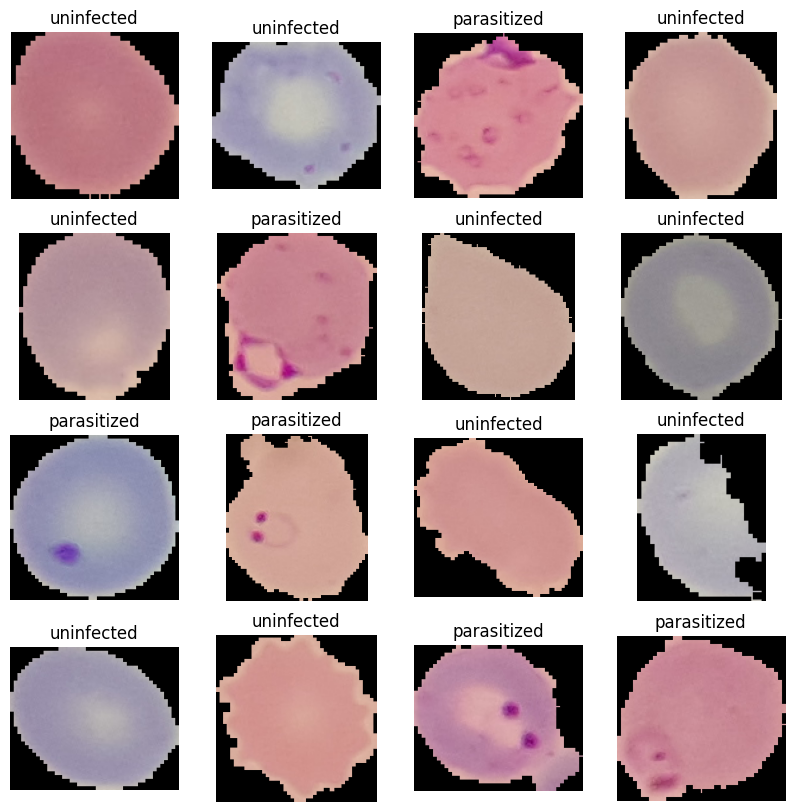

In [15]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [16]:
IMAGE_SIZE = 224

In [17]:
def image_resize_normalize (image , label ) :
  image = tf.image.resize(image , (IMAGE_SIZE ,IMAGE_SIZE)) /255
  return image , label

In [18]:
train_dataset =  train_dataset.map(image_resize_normalize)
test_dataset =  test_dataset.map(image_resize_normalize)
val_dataset = val_dataset.map(image_resize_normalize)

In [19]:
for data in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], shape=(124, 127, 3), dtype=uint8) tf.Tensor(0, shape=(), dtype=int64)


In [20]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size = 8 ,reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [21]:
val_dataset = val_dataset.shuffle(buffer_size = 8 ,reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [22]:
test_dataset = test_dataset.shuffle(buffer_size = 8 ,reshuffle_each_iteration=True).batch(1).prefetch(tf.data.AUTOTUNE)

In [23]:
model = Sequential([
    InputLayer(input_shape =(IMAGE_SIZE ,IMAGE_SIZE,3)),
    Conv2D(filters = 6 ,kernel_size= 6 ,padding ='valid' , activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2) , strides=2),


     Conv2D(filters = 16 ,kernel_size= 3 ,padding ='valid' , activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2) , strides=2),

    Flatten(),
    Dense(100 , activation = 'relu'),
    BatchNormalization(),

    Dense(10 , activation = 'relu'),
    BatchNormalization(),

    Dense(1 , activation = 'sigmoid'),



])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 219, 219, 6)       654       
                                                                 
 batch_normalization (Batch  (None, 219, 219, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 109, 109, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 107, 107, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 107, 107, 16)      64        
 chNormalization)                                                
                                                        

In [25]:
metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
                BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

In [26]:
model.compile(optimizer = Adam(learning_rate= 0.01),
loss = BinaryCrossentropy(),
              metrics=metrics,
              )

In [27]:
history = model.fit(train_dataset , validation_data=val_dataset ,epochs=3 , verbose = 1)

Epoch 1/3
689/689 [==============================] - 94s 113ms/step - loss: 0.5612 - tp: 7653.0000 - fp: 3144.0000 - tn: 7879.0000 - fn: 3370.0000 - accuracy: 0.7045 - precision: 0.7088 - recall: 0.6943 - auc: 0.7795 - val_loss: 2.8114 - val_tp: 1359.0000 - val_fp: 1375.0000 - val_tn: 20.0000 - val_fn: 1.0000 - val_accuracy: 0.5005 - val_precision: 0.4971 - val_recall: 0.9993 - val_auc: 0.6159
Epoch 2/3
689/689 [==============================] - 45s 66ms/step - loss: 0.2347 - tp: 10194.0000 - fp: 994.0000 - tn: 10026.0000 - fn: 832.0000 - accuracy: 0.9172 - precision: 0.9112 - recall: 0.9245 - auc: 0.9627 - val_loss: 0.4769 - val_tp: 1044.0000 - val_fp: 297.0000 - val_tn: 1093.0000 - val_fn: 321.0000 - val_accuracy: 0.7757 - val_precision: 0.7785 - val_recall: 0.7648 - val_auc: 0.8560
Epoch 3/3
689/689 [==============================] - 44s 64ms/step - loss: 0.2049 - tp: 10326.0000 - fp: 818.0000 - tn: 10206.0000 - fn: 696.0000 - accuracy: 0.9313 - precision: 0.9266 - recall: 0.9369 - 

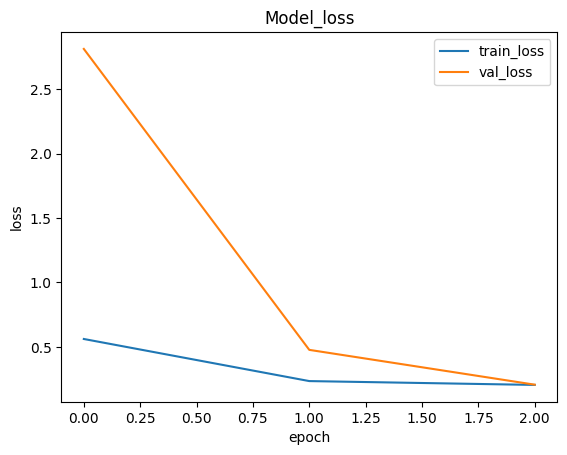

In [28]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()


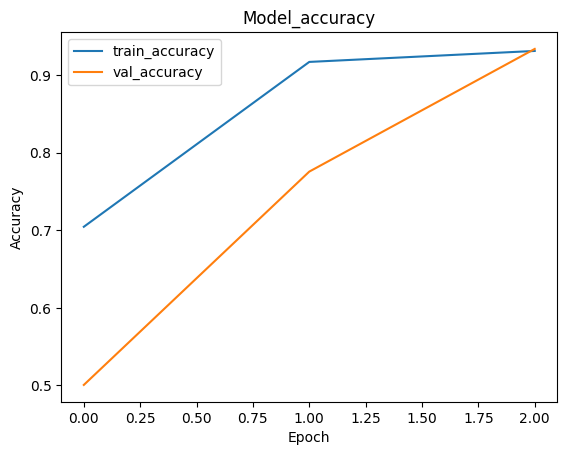

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [30]:
model.evaluate(test_dataset)


2755/2755 [==============================] - 26s 6ms/step - loss: 0.1911 - tp: 1331.0000 - fp: 105.0000 - tn: 1262.0000 - fn: 57.0000 - accuracy: 0.9412 - precision: 0.9269 - recall: 0.9589 - auc: 0.9783


[0.1911240518093109,
 1331.0,
 105.0,
 1262.0,
 57.0,
 0.9411978125572205,
 0.9268802404403687,
 0.9589337110519409,
 0.9783443212509155]

In [31]:
def paraside_or_not(x):
  if(x < 0.5):
    return str('P')
  else:
    return str('U')

1/1 [==============================] - 0s 18ms/step


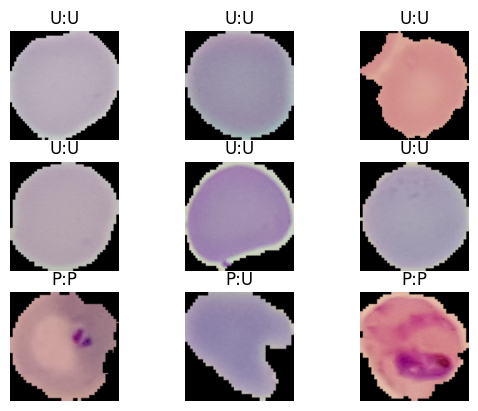

In [32]:

for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0])
  plt.title(str(paraside_or_not(label.numpy()[0])) + ":" +str(paraside_or_not(model.predict(image)[0][0])))
  plt.axis('off')

In [33]:
labels = []
images = []

for i, (image, label) in enumerate(test_dataset):
      labels.append(label.numpy()[0])
      images.append(model.predict(image)[0][0])

1/1 [==============================] - 0s 22ms/step


In [34]:
len(labels)

2755

In [35]:
len(images)

2755

In [36]:
print(labels[:10])

[1, 1, 0, 1, 0, 1, 0, 0, 0, 1]


In [37]:
print(images[:10])

[0.9169579, 0.8848328, 0.0028558983, 0.8792784, 0.0045884307, 0.68155384, 0.7891363, 0.007040045, 0.046567455, 0.9677154]


In [38]:
y_test = np.array(labels)
y_pred_proba = np.array(images)

In [39]:
def prediction (pred):
  if pred >=0.5 :
    return 1
  else:
    return 0;

In [48]:
y_pred = np.where(y_pred_proba >= 0.5, 1, 0)
print(y_pred[:10])

[1 1 0 1 0 1 1 0 0 1]


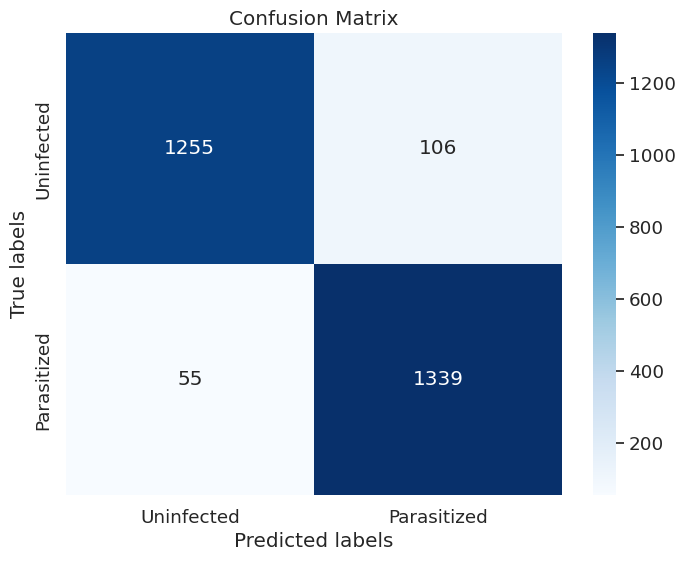

In [49]:
cm = confusion_matrix(y_test ,y_pred )
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Uninfected','Parasitized'], yticklabels=['Uninfected','Parasitized'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [42]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

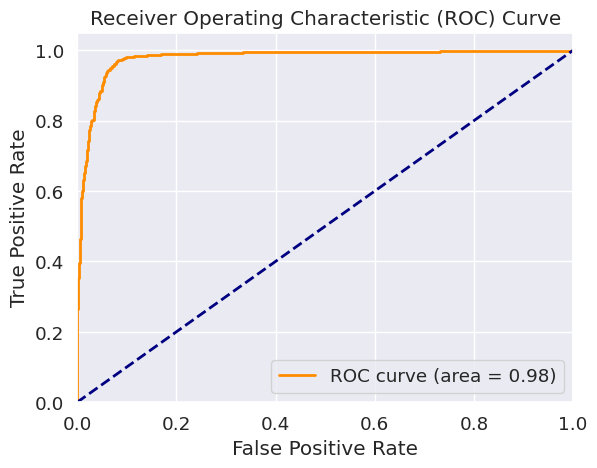

In [43]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [44]:
from sklearn.metrics import precision_score, recall_score ,f1_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [45]:
print(f"precision = {precision}")
print(f"recall = {recall}")
print(f"f1 score = {f1}")

precision = 0.9266435986159169
recall = 0.960545193687231
f1 score = 0.943289890806622
